In [1]:
from utils import *
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch

In [2]:
data = np.load('./data/money_laundrying_dataset/data.npy', allow_pickle=True)[()]
X = data['X']
y = data['y']
print(X.shape, y.shape)

(1875, 1000, 1) (1875,)


In [3]:
X_train, X_test, y_train, y_test =\
                    train_test_split(X, y, random_state=0, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1406, 1000, 1) (469, 1000, 1) (1406,) (469,)


In [4]:
X_train = X_train[:,:,:1]
X_test = X_test[:,:,:1]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1406, 1000, 1) (469, 1000, 1) (1406,) (469,)


In [5]:
train_per = sum(y_train)/y_train.shape[0]
print('TrainSet Percentage of Postive Samples = {}'.format(train_per))
test_per = sum(y_test)/y_test.shape[0]
print('TestSet Percentage of Postive Samples = {}'.format(test_per))

TrainSet Percentage of Postive Samples = 0.4018492176386913
TestSet Percentage of Postive Samples = 0.39445628997867804


In [6]:
#Scaler
X_train = preprocessing.scale(X_train.squeeze())
X_train = X_train[:,:,np.newaxis]
X_test = preprocessing.scale(X_test.squeeze())
X_test = X_test[:,:,np.newaxis]
print(X_train.shape, X_test.shape)

(1406, 1000, 1) (469, 1000, 1)


In [7]:
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))
print(n_ts, ts_sz, n_classes)

1406 1000 2


In [8]:
shp_len = 10
shp_num = 100
shapelet_sizes = {shp_len: shp_num}
shapelet_sizes

{10: 100}

In [9]:
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=50,
                            random_state= 42,
                            verbose=1)
shp_clf.fit(X_train, y_train)

Epoch 1/50
88/88 [==============================] - 0s 4ms/step - loss: 12.7837 - binary_accuracy: 0.5676 - binary_crossentropy: 12.7644
Epoch 2/50
88/88 [==============================] - 0s 4ms/step - loss: 3.4256 - binary_accuracy: 0.5967 - binary_crossentropy: 3.4063
Epoch 3/50
88/88 [==============================] - 0s 4ms/step - loss: 7.6861 - binary_accuracy: 0.5768 - binary_crossentropy: 7.6662
Epoch 4/50
88/88 [==============================] - 0s 4ms/step - loss: 2.9962 - binary_accuracy: 0.6088 - binary_crossentropy: 2.9762
Epoch 5/50
88/88 [==============================] - 0s 4ms/step - loss: 2.5201 - binary_accuracy: 0.6366 - binary_crossentropy: 2.5006
Epoch 6/50
88/88 [==============================] - 0s 4ms/step - loss: 3.2099 - binary_accuracy: 0.5782 - binary_crossentropy: 3.1907
Epoch 7/50
88/88 [==============================] - 0s 4ms/step - loss: 8.0685 - binary_accuracy: 0.5605 - binary_crossentropy: 8.0484
Epoch 8/50
88/88 [==============================] - 0

LearningShapelets(batch_size=16, max_iter=50, n_shapelets_per_size={10: 100},
                  optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f138df9b130>,
                  random_state=42, verbose=1, weight_regularizer=0.01)

In [10]:
# Train set
pred_labels = shp_clf.predict(X_train)
print("accuracy:", accuracy_score(y_train, pred_labels))
print("precision:", precision_score(y_train, pred_labels))
print('recall:', recall_score(y_train, pred_labels))
print('f1-score:', f1_score(y_train, pred_labels))

88/88 [==============================] - 0s 1ms/step
accuracy: 0.7190611664295875
precision: 0.8512396694214877
recall: 0.36460176991150445
f1-score: 0.5105328376703842


In [11]:
# Test set
pred_labels = shp_clf.predict(X_test)
print("accuracy:", accuracy_score(y_test, pred_labels))
print("precision:", precision_score(y_test, pred_labels))
print('recall:', recall_score(y_test, pred_labels))
print('f1-score:', f1_score(y_test, pred_labels))

30/30 [==============================] - 0s 1ms/step
accuracy: 0.7057569296375267
precision: 0.7422680412371134
recall: 0.3891891891891892
f1-score: 0.5106382978723404


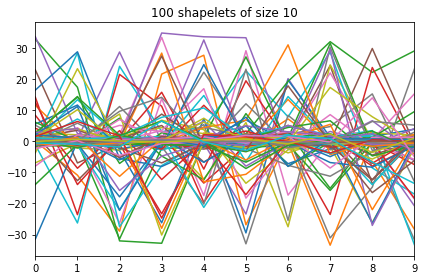

In [13]:
# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])
    #plt.ylim([0,10000])
plt.tight_layout()
plt.show()